<a href="https://colab.research.google.com/github/avilash01/Gold-price-prediction/blob/main/Gold_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
farzadnekouei_gold_price_10_years_20132023_path = kagglehub.dataset_download('farzadnekouei/gold-price-10-years-20132023')

print('Data source import complete.')


Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


![Gold_Price_Prediction_Slide.jpg](attachment:Gold_Price_Prediction_Slide.jpg)

__In this notebook, we are going to build a time series model to predict the future price of gold, which can be very useful for traders. For this purpose, we use the historical gold price data for 10 years (from 2013 to 2023).__

### Let's get started:

# Step 1: Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Step 2: Reading Dataset

In [ ]:
df = pd.read_csv('/kaggle/input/gold-price-10-years-20132023/Gold Price (2013-2023).csv')

# Step 3: Dataset Overview

In [ ]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
4,12/26/2022,"1,809.70","1,805.80","1,811.95","1,805.55",NaN,0.30%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


__As you can see, the data set includes daily gold price information including daily Open, High and Low prices and the final price of each day (Price) along with the volume of transactions and price changes in each day.__

__Dataset Basic Information:__

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2583 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2583 non-null   object
 1   Price     2583 non-null   object
 2   Open      2583 non-null   object
 3   High      2583 non-null   object
 4   Low       2583 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2583 non-null   object
dtypes: object(7)
memory usage: 141.4+ KB


__All variables are stored as object.__

# Step 4: Data Preparation

## Step 4.1: Feature Subset Selection
__Since we will not use Vol. and Change % features to predict Price, we will drop these two features:__

In [ ]:
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

## Step 4.2: Transforming Data

__Date feature is stored as object in the data frame. To increase the speed of calculations, we convert it's data type to datetime and then sort this feature in ascending order:__

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

__The " , " sign is redundant in the dataset. First, we remove it from the entire dataset and then change the data type of the numerical variables to float:__

In [ ]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

__Result:__

In [ ]:
df.head()

## Step 4.3: Checking Duplicates
__There are no duplicate samples in Date feature:__

In [ ]:
df.duplicated().sum()

np.int64(0)

## Step 4.4: Checking Missing Values
__There are no missing values in the dataset:__

In [ ]:
df.isnull().sum().sum()

np.int64(0)

# Step 5: Visualizing Gold Price History Data

__Interactive Gold Price Chart:__

In [ ]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black')
fig.update_layout(xaxis_title="Date",
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

# Step 6: Splitting Data to Training & Test Sets
__Since we cannot train on future data in time series data, we should not divide the time series data randomly. In time series splitting, testing set is always later than training set. We consider the last year for testing and everything else for training:__

In [ ]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

260

R-squared: 0.5387


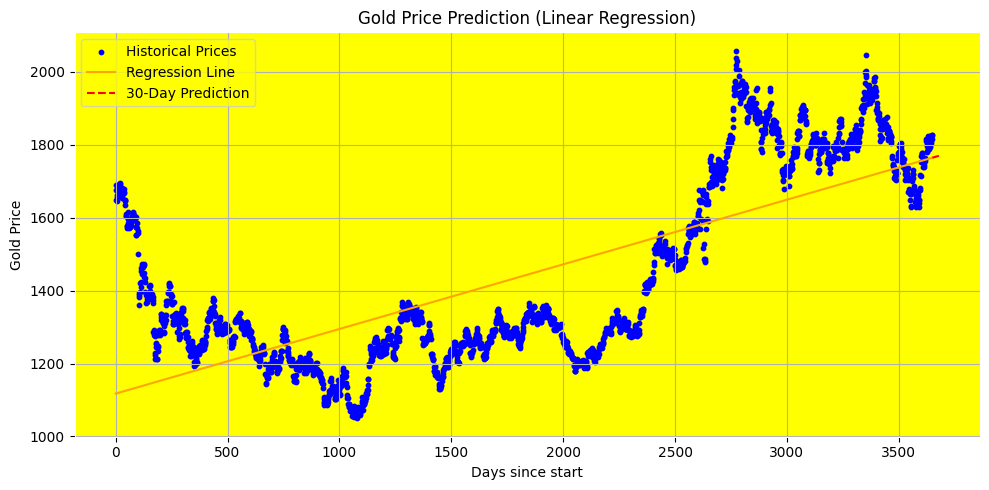

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].astype(str).str.replace(',', '').astype(float)

# Add 'Days' column since the start
df['Days'] = (df['Date'] - df['Date'].min()).dt.days

# Features and target
X = df[['Days']]
y = df['Price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Predict next 30 days
future_days = pd.DataFrame({'Days': np.arange(df['Days'].max() + 1, df['Days'].max() + 31)})
future_prices = model.predict(future_days)

# R-squared score
r_squared = r2_score(y_test, y_pred)
print(f"R-squared: {r_squared:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.scatter(df['Days'], df['Price'], color='blue', label='Historical Prices', s=10)
plt.plot(X, model.predict(X), color='orange', label='Regression Line')
plt.plot(future_days['Days'], future_prices, color='red', linestyle='dashed', label='30-Day Prediction')
plt.xlabel('Days since start')
plt.ylabel('Gold Price')
plt.title('Gold Price Prediction (Linear Regression)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()